# Getting started with DoWhy: A simple example
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and estimate the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.

First, let us load all required packages.

In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=20000, 
        treatment_is_binary=True,
        num_discrete_common_causes=1)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0        W1        W2        W3 W4    v0  \
0 -0.119434  0.0  0.610517  0.360747 -1.301787  1.177112  0.992263  2  True   
1  1.227033  1.0  0.060819  0.530126 -0.182658  3.060546  0.892519  0  True   
2  3.217984  0.0  0.973915 -0.769760 -0.607159  1.079276 -1.107614  0  True   
3  1.067852  0.0  0.582752 -0.342469 -0.608328 -1.287410  0.976956  3  True   
4  1.823178  1.0  0.650570 -0.889167  1.091130 -0.334163  1.716186  0  True   

           y  
0  13.019897  
1  22.760496  
2  16.350150  
3  14.790487  
4  22.477603  
digraph { U[label="Unobserved Confounders"]; U->y;v0->y;U->v0;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ 

In [18]:
data['df']

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y,propensity_score,strata,dbar,d_y,dbar_y
0,-0.119434,0.0,0.610517,0.360747,-1.301787,1.177112,0.992263,2,True,13.019897,0.995248,29.0,0,13.019897,0.0
1,1.227033,1.0,0.060819,0.530126,-0.182658,3.060546,0.892519,0,True,22.760496,0.998942,39.0,0,22.760496,0.0
2,3.217984,0.0,0.973915,-0.769760,-0.607159,1.079276,-1.107614,0,True,16.350150,0.861894,7.0,0,16.350150,0.0
3,1.067852,0.0,0.582752,-0.342469,-0.608328,-1.287410,0.976956,3,True,14.790487,0.976880,17.0,0,14.790487,0.0
4,1.823178,1.0,0.650570,-0.889167,1.091130,-0.334163,1.716186,0,True,22.477603,0.964112,14.0,0,22.477603,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.010779,0.0,0.719221,-0.573581,-0.154512,-1.680311,-0.016755,2,True,7.359310,0.923428,10.0,0,7.359310,0.0
19996,0.726049,0.0,0.533595,0.321504,-0.546159,-0.415960,0.382982,0,True,11.871691,0.917243,9.0,0,11.871691,0.0
19997,0.157215,0.0,0.339548,1.860097,1.417669,-0.472603,0.633138,3,True,23.748984,0.999979,49.0,0,23.748984,0.0
19998,1.248974,1.0,0.966467,-1.018494,0.042078,0.972270,0.691898,0,True,15.930571,0.935521,11.0,0,15.930571,0.0


Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Interface 1 (recommended): Input causal graph

We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

To create the causal graph for your dataset, you can use a tool like [DAGitty](http://dagitty.net/dags.html#) that provides a GUI to construct the graph. You can export the graph string that it generates. The graph string is very close to the DOT format: just rename `dag` to `digraph`, remove newlines and add a semicolon after every line, to convert it to the DOT format and input to DoWhy. 

In [3]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

In [17]:
data["treatment_name"]

['v0']

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify 
the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

**DoWhy philosophy: Keep identification and estimation separate**

Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step.
It is important to understand that these are orthogonal steps.

* Identification

In [10]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W1,W2,W0,W3,W4,X0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,W4,X0,U) = P(y|v0,W1,W2,W0,W3,W4,X0)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Note the parameter flag *proceed\_when\_unidentifiable*. It needs to be set to *True* to convey the assumption that we are ignoring any unobserved confounding. The default behavior is to prompt the user to double-check that the unobserved confounders can be ignored. 

* Estimation

In [11]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W1,W2,W0,W3,W4,X0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,W4,X0,U) = P(y|v0,W1,W2,W0,W3,W4,X0)

## Realized estimand
b: y~v0+W1+W2+W0+W3+W4+X0
Target units: ate

## Estimate
Mean value: 12.22245148106945

Causal Estimate is 12.22245148106945


You can input additional parameters to the estimate_effect method. For instance, to estimate the effect on any subset of the units, you can specify the "target_units" parameter which can be a string ("ate", "att", or "atc"), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. You can also specify "effect modifiers" to estimate heterogeneous effects across these variables. See `help(CausalModel.estimate_effect)`. 

In [12]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W1,W2,W0,W3,W4,X0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,W4,X0,U) = P(y|v0,W1,W2,W0,W3,W4,X0)

## Realized estimand
b: y~v0+W1+W2+W0+W3+W4+X0
Target units: atc

## Estimate
Mean value: 12.085030088973811

Causal Estimate is 12.085030088973811


## Interface 2: Specify common causes and instruments

In [9]:
# Without graph                                       
model= CausalModel(                             
        data=df,                                      
        treatment=data["treatment_name"],             
        outcome=data["outcome_name"],                 
        common_causes=data["common_causes_names"],
        effect_modifiers=data["effect_modifier_names"])                         

In [10]:
model.view_model()

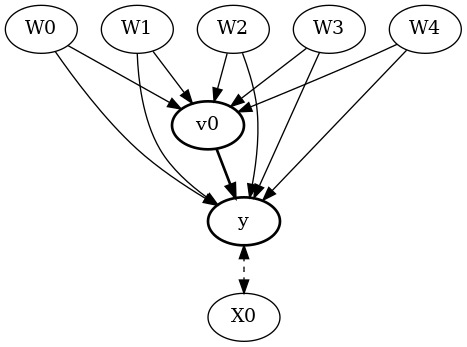

In [11]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get the same causal graph. Now identification and estimation is done as before.

In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)                         

* Estimation

In [13]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")         
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W3,W1,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,W4,U) = P(y|v0,W0,W3,W1,W2,W4)

## Realized estimand
b: y~v0+W0+W3+W1+W2+W4
Target units: ate

## Estimate
Mean value: 9.60353896239299

Causal Estimate is 9.60353896239299


## Refuting the estimate

Let us now look at ways of refuting the estimate obtained.

### Adding a random common cause variable

In [14]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:9.60353896239299
New effect:9.602995259163794



### Adding an unobserved common cause variable

In [15]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:9.60353896239299
New effect:7.591550789699005



### Replacing treatment with a random (placebo) variable

In [16]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:9.60353896239299
New effect:0.005166426876598622
p value:0.47



### Removing a random subset of the data

In [17]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


Refute: Use a subset of data
Estimated effect:9.60353896239299
New effect:9.6152898407909
p value:0.42



As you can see, the propensity score stratification estimator is reasonably robust to refutations.
For reproducibility, you can add a parameter "random_seed" to any refutation method, as shown below.

In [18]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:9.60353896239299
New effect:9.618271557173077
p value:0.33

